In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
import seaborn as sns
from scipy.stats import skew
from sklearn.metrics import mean_squared_error

In [21]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20
train_file_path = '/home/matheus/PycharmProjects/HousePrices/data/train.csv'
test_file_path = '/home/matheus/PycharmProjects/HousePrices/data/test.csv'
train = pd.read_csv(train_file_path)
test = pd.read_csv(test_file_path)

all_data = pd.concat([train.loc[:,:"SaleCondition"], test.loc[:,:"SaleCondition"]], sort = False)
numeric_feats = all_data.loc[:, :"SaleCondition"].dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data.loc[:,numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
change_to_none = ["Alley", "MasVnrType","MiscFeature"]
change_to_no = ["BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2",
                "FireplaceQu", "GarageType","PoolQC","Fence"]
all_data.loc[:, "MasVnrArea"] = all_data.loc[:, "MasVnrArea"].fillna(0)
all_data.loc[:,change_to_none] = all_data.loc[:,change_to_none].fillna("None")
all_data.loc[:,change_to_no] = all_data.loc[:,change_to_no].fillna("No") 

all_data = all_data.fillna(all_data.mean())
all_data.columns[all_data.isna().any()].tolist()
all_data = pd.get_dummies(all_data)
train = pd.get_dummies(train)
train['SalePrice'] = np.log1p(train['SalePrice'])
def list_corr(var="SalePrice", ascend=True):
    corr_m = train.corr().sort_values(var,ascending=ascend)
    return corr_m[var]
corr = list_corr()

positive = corr.where(corr>0.1).dropna().keys()

negative = corr.where(corr<-0.1).dropna().keys()
print(negative.shape)
features = positive
def matriz_corr(features):
    #correlation matrix
    corrmat = train[features].corr()
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, square=True);

(62,)


In [22]:
list_corr(ascend=False)

SalePrice                1.000000
OverallQual              0.817185
GrLivArea                0.700927
GarageCars               0.680625
GarageArea               0.650888
TotalBsmtSF              0.612134
1stFlrSF                 0.596981
FullBath                 0.594771
YearBuilt                0.586570
YearRemodAdd             0.565608
GarageYrBlt              0.541073
TotRmsAbvGrd             0.534422
Foundation_PConc         0.530840
ExterQual_Gd             0.509675
Fireplaces               0.489450
HeatingQC_Ex             0.466706
BsmtQual_Ex              0.463991
BsmtFinType1_GLQ         0.440764
MasVnrArea               0.430809
GarageFinish_Fin         0.418881
GarageType_Attchd        0.415787
KitchenQual_Ex           0.413937
KitchenQual_Gd           0.406601
BsmtFinSF1               0.372023
GarageCond_TA            0.365783
ExterQual_Ex             0.356134
LotFrontage              0.355879
Neighborhood_NridgHt     0.351803
CentralAir_Y             0.351599
FireplaceQu_Gd

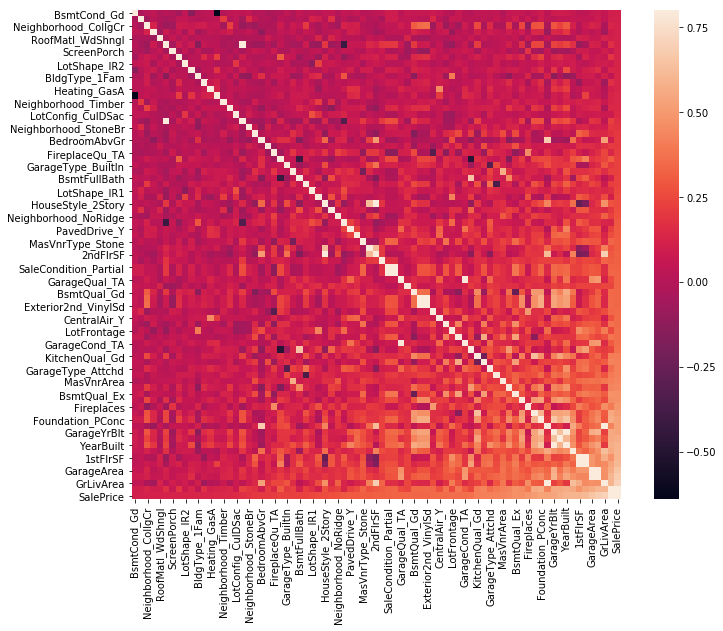

In [23]:
matriz_corr(positive)

In [32]:
features_to_drop = ["GarageArea","1stFlrSF","TotRmsAbvGrd","GarageYrBlt", "GarageCond_TA","HouseStyle_2Story", "SalePrice"]
features = pd.Index(["Id"]).append(positive.drop(features_to_drop))
print(features)
all_data = all_data.loc[:, features]

Index(['Id', 'BsmtCond_Gd', 'LandContour_HLS', 'Neighborhood_CollgCr',
       'Condition1_Norm', 'RoofMatl_WdShngl', 'MSZoning_FV', 'ScreenPorch',
       'BsmtFinType2_Unf', 'LotShape_IR2', 'ExterCond_TA', 'BldgType_1Fam',
       'Functional_Typ', 'Heating_GasA', 'BsmtCond_TA', 'Neighborhood_Timber',
       'BsmtExposure_Av', 'LotConfig_CulDSac', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'RoofStyle_Hip', 'BedroomAbvGr',
       'FireplaceQu_Ex', 'FireplaceQu_TA', 'BsmtUnfSF', 'GarageType_BuiltIn',
       'MasVnrType_BrkFace', 'BsmtFullBath', 'GarageFinish_RFn',
       'LotShape_IR1', 'LotArea', 'BsmtExposure_Gd', 'Neighborhood_NoRidge',
       'MSZoning_RL', 'PavedDrive_Y', 'Electrical_SBrkr', 'MasVnrType_Stone',
       'HalfBath', '2ndFlrSF', 'OpenPorchSF', 'SaleCondition_Partial',
       'SaleType_New', 'GarageQual_TA', 'WoodDeckSF', 'BsmtQual_Gd',
       'Exterior1st_VinylSd', 'Exterior2nd_VinylSd', 'FireplaceQu_Gd',
       'CentralAir_Y', 'Neighborhood_NridgHt', 'LotFro

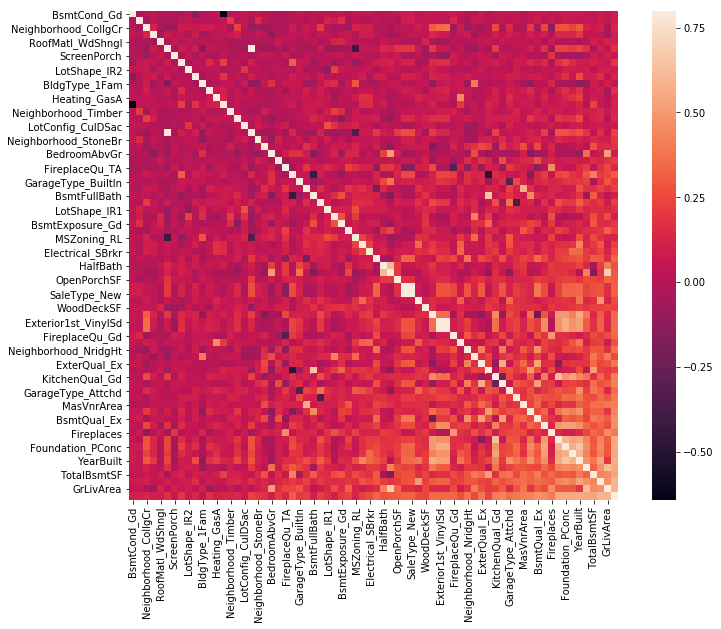

In [33]:
matriz_corr(features[1:])

/home/matheus/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


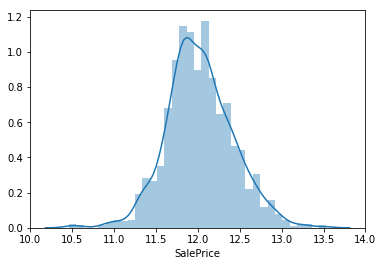

In [34]:

sns.distplot(train['SalePrice']) 

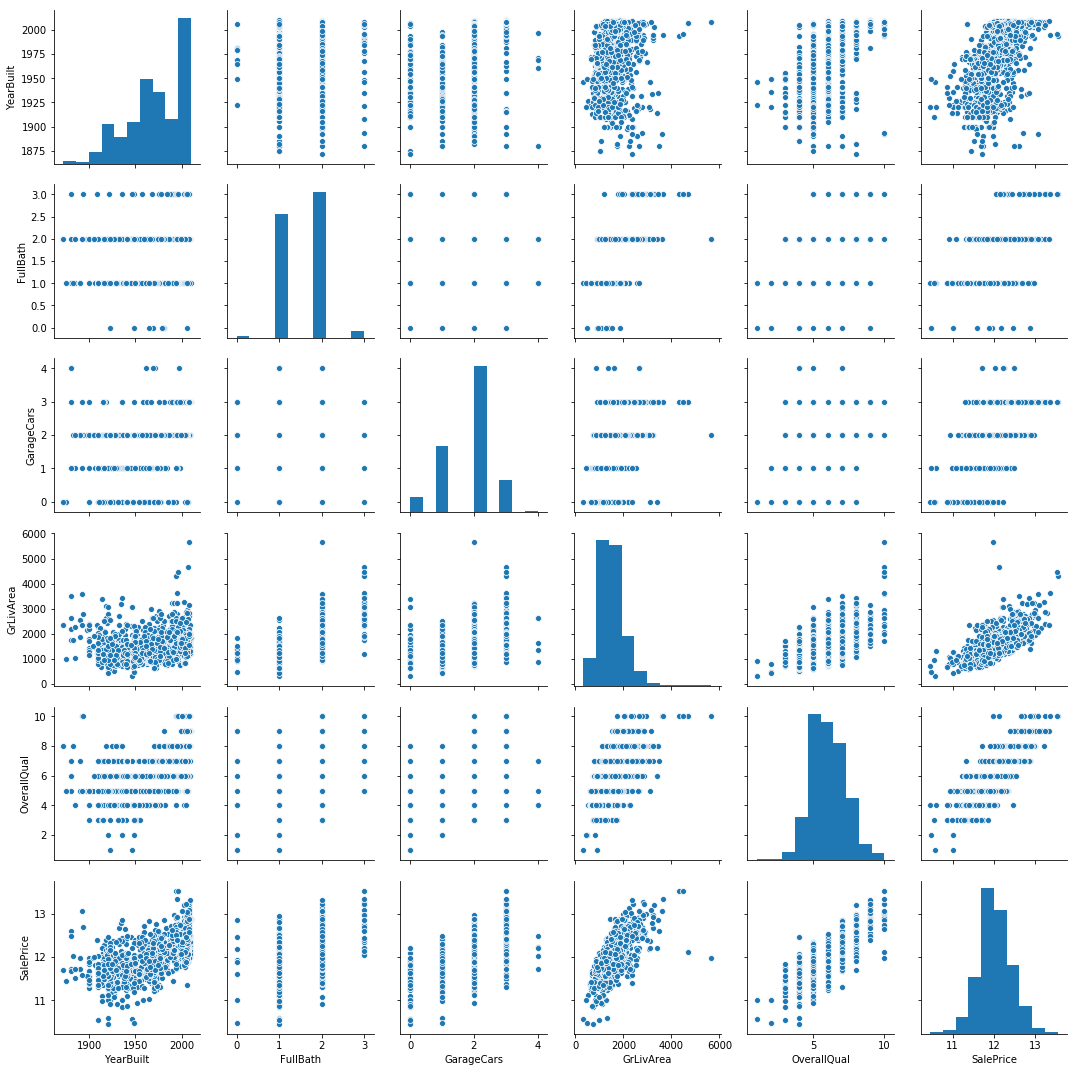

In [35]:
cols = ['YearBuilt', 'FullBath', 'GarageCars',
       'GrLivArea', 'OverallQual','SalePrice']
sns.pairplot(train[cols], height = 2.5)

In [36]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model, X, y):
    rmse= np.sqrt(-cross_val_score(model,X, y, scoring="neg_mean_squared_error", cv = 5))
    return rmse

In [37]:
from sklearn.linear_model import Ridge, SGDRegressor
X = all_data[:train.shape[0]]
y = train.SalePrice
X_test = all_data[train.shape[0]:]

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha),X,y).mean() 
            for alpha in alphas]
y.shape

(1460,)

Text(0, 0.5, 'rmse')

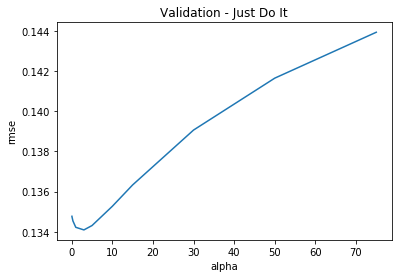

In [38]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [23]:
#test.loc[0,"Neighborhood_NridgHt":"OverallQual"].values
cv_ridge.idxmin()
rmse_cv(SGDRegressor(max_iter=10000,tol=0.00001),X,y).mean()

6289972747997232.0

In [49]:
def residual_plot(y_train_pred,y):
    y_rsd = y_train_pred - y
    plt.scatter(y_train_pred, y_rsd, c = "blue", label = "Training data")
    plt.xlabel("Predict Values")
    plt.ylabel("Residuals")
    plt.hlines(y = 0, xmin = min(y_train_pred), xmax =  max(y_train_pred), color = "red")# plotar a reta

Best alpha : 3.0


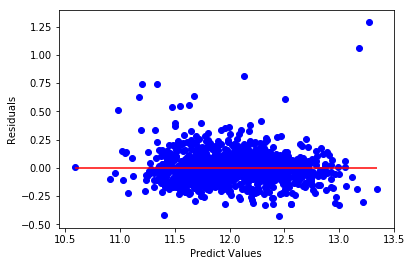

In [50]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]).fit(X,y)
alpha = ridge.alpha_
print("Best alpha :", alpha)
residual_plot(ridge.predict(X), y)

Text(0, 0.5, 'Residuals')

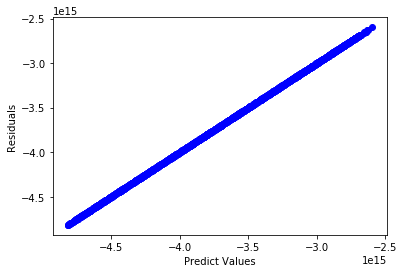

In [51]:
sgd = SGDRegressor(max_iter=1000, tol=0.0001).fit(X,y)
y_pred = sgd.predict(X)
r = y_pred - y
plt.scatter(y_pred, r, c = 'blue', label = "Training data")
plt.xlabel("Predict Values")
plt.ylabel("Residuals")

In [52]:
ridge_preds = ridge.predict(X_test)
cridge_preds)

array([108310.22972298, 155725.52156897, 178364.00502169, ...,
       169334.93254653, 115061.85613998, 227739.68878526])

In [54]:
model_lasso = LassoCV(alphas=[0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60],cv=5)
rmse_cv(model_lasso,X,y).mean()

0.15202515144980472

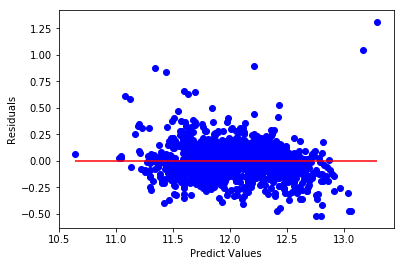

In [58]:
model_lasso.fit(X,y)
lasso_preds = np.expm1(model_lasso.predict(X_test))
residual_plot( model_lasso.predict(X), y)

In [59]:
lasso_preds

array([125708.61472336, 154234.50410309, 186527.13172938, ...,
       170868.33166582, 132500.06304768, 246254.3628508 ])

0.016133983252856275
0.022661872335494968
0.016267921203448846


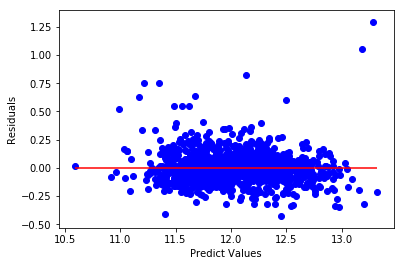

In [69]:
rp = ridge.predict(X)
lp = model_lasso.predict(X)
train_preds = 0.7*rp + 0.3*lp
print(mean_squared_error(rp ,y))
print(mean_squared_error(lp, y))
print(mean_squared_error(train_preds, y))
residual_plot(train_preds, y)

In [82]:
preds = np.expm1(ridge_preds)
submission = pd.DataFrame({'Id':test.Id,'SalePrice':preds})

,Id,SalePrice
0,1461,108310.229723
1,1462,155725.521569
2,1463,178364.005022
3,1464,195261.579917
4,1465,218903.076823
5,1466,170717.616615
6,1467,173381.654223
7,1468,162815.338333
8,1469,194048.333517
9,1470,120793.792584


In [83]:
submission.to_csv('submission.csv',index=False)
pd.read_csv('submission.csv')

,Id,SalePrice
0,1461,108310.229723
1,1462,155725.521569
2,1463,178364.005022
3,1464,195261.579917
4,1465,218903.076823
5,1466,170717.616615
6,1467,173381.654223
7,1468,162815.338333
8,1469,194048.333517
9,1470,120793.792584
